In [1]:
import os 
os.environ['http_proxy'] = 'http://proxy:80'
os.environ['https_proxy'] = 'http://proxy:80'

In [2]:
!pip install tensorflow-empirical-privacy
!pip install --upgrade tensorflow-estimator==2.15.0

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
#from tensorflow.keras import ops

import numpy as np
import matplotlib.pyplot as plt
import random

2024-09-07 21:59:26.143067: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 21:59:26.143247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 21:59:26.384633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 21:59:26.872948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 21:59:31.649918: W tensorflow/compiler/tf2

In [ ]:
from modelblocks.Augmentation import get_train_augmentation_model, get_test_augmentation_model, data_augmentation
from modelblocks.Blocks import Patches, PatchEncoder

In [4]:
BUFFER_SIZE = 1024
BATCH_SIZE = 256
INPUT_SHAPE = (32, 32, 3)
AUTO = tf.data.AUTOTUNE

**Loading the dataset**

In [5]:
(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar100.load_data()
print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_valid)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(x_valid)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTO)

Training samples: 50000
Testing samples: 10000


2024-09-07 21:59:45.699643: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10525 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-09-07 21:59:45.700387: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10525 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:83:00.0, compute capability: 6.1


In [6]:
#The original DMAE Paper mentions that augmentation does not provide any significant performance improvement
#But we'll still be adding it since that makes the model more robust

In [7]:
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

In [8]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            L.Rescaling(1 / 255.0),
            L.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            L.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            L.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [L.Rescaling(1 / 255.0), L.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

**Divide image into patches**

In [9]:
class Patches(L.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = L.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.suptitle('Original Image')
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        plt.suptitle('Patches')
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 135.


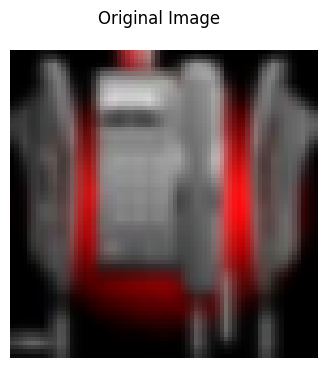

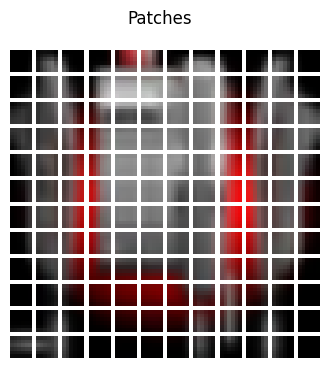

In [10]:
image_batch = next(iter(train_ds))

augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

patch_layer = Patches()
patches = patch_layer(images=augmented_images)
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

In [11]:
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 64
DEC_PROJECTION_DIM = 48
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [12]:
EPOCHS = 100
DOWNSTREAM_EPOCHS = 10

**Patch Encoder**

In [13]:
class PatchEncoder(L.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape
        self.projection = L.Dense(units=self.projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            )

    def get_random_indices(self, batch_size):
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]
        new_patch = np.zeros_like(patch)
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

**Teacher Network**

In [14]:
class PatchEncoder_ViT(L.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection = L.Dense(units=projection_dim)
        self.position_embedding = L.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [15]:
teacher_config = {
    'projection_dim': 128,
    'num_heads' : 4,
    'transformer_layers' : 8,
    'mlp_head_units': [2048, 1024]
}


teacher_config['transformer_units'] = [
    teacher_config['projection_dim'] * 2,
    teacher_config['projection_dim']
]


In [16]:
data_augmentation = keras.Sequential(
    [
        L.Normalization(),
        L.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        L.RandomFlip("horizontal"),
        L.RandomRotation(factor=0.02),
        L.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [17]:
def dense_projection(x, dropout_rate, hidden_units, name = None):
    for units in hidden_units:
        if name:
            #print(name + '_' + str(units))
            x = L.Dense(units, activation=tf.nn.gelu, name = name + '_' + str(units))(x)
        else:
            x = L.Dense(units, activation=tf.nn.gelu)(x)
        x = L.Dropout(dropout_rate)(x)
    return x

In [18]:
from os import name
def create_vit_classifier():
    inputs = keras.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(PATCH_SIZE)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(NUM_PATCHES, teacher_config['projection_dim'], downstream=True)(patches)

    # Create multiple layers of the Transformer block.
    for i in range(teacher_config['transformer_layers']):
        # Layer normalization 1.
        x1 = L.LayerNormalization(epsilon=1e-6, name = f"vit_lnorm_{i}__1")(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = L.MultiHeadAttention(
            num_heads=teacher_config['num_heads'], key_dim=teacher_config['projection_dim'], dropout=0.1,
            name=f"vit_attention_{i}"
        )(x1, x1)
        # Skip connection 1.
        x2 = L.Add(name = f"vit_add_{i}")([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = L.LayerNormalization(epsilon=1e-6, name = f"vit_lnorm_{i}__2")(x2)
        # MLP.
        x3 = dense_projection(x3, hidden_units=teacher_config['transformer_units'], dropout_rate=0.1, name = f"vit_dense_{i}")
        # Skip connection 2.
        encoded_patches = L.Add(name = f"vit_add_{i}_2")([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = L.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = L.Flatten()(representation)
    representation = L.Dropout(0.5)(representation)
    # Add MLP.
    features = dense_projection(representation, hidden_units=teacher_config['mlp_head_units'], dropout_rate=0.5)
    # Classify outputs.
    num_classes = 100
    logits = L.Dense(100)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    fe_model = keras.Model(inputs=inputs, outputs=model.get_layer("vit_dense_5_128").output, name="vit_interim")
    return model, fe_model

In [19]:
vit_classifier, vit_interim = create_vit_classifier()

In [20]:
vit_classifier.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

In [21]:
vit_classifier.load_weights('./weights_teacher/vit_128_v1.ckpt')

In [22]:
for layer_ in vit_classifier.layers:
    layer_.trainable=False

In [23]:
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_valid, y_valid)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


313/313 [==============================] - 13s 31ms/step - loss: 2.2016 - accuracy: 0.5206 - top-5-accuracy: 0.7848
Test accuracy: 52.06%
Test top 5 accuracy: 78.48%


In [24]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=0.001, weight_decay=0.0001
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    #checkpoint_filepath = "/chkpt/checkpoint.weights.h5"
    #checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #    checkpoint_filepath,
    #    monitor="val_accuracy",
    #    save_best_only=True,
    #    save_weights_only=True,
    #)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=75,
        validation_split=0.1,
        callbacks=[],
    )

    #model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_valid, y_valid)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


#vit_classifier = create_vit_classifier()
#history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


#plot_history("loss")
#plot_history("top-5-accuracy")

In [25]:
#vit_classifier.save_weights('./weights_teacher/vit_128_v1.ckpt')

In [26]:
for layer_ in vit_classifier.layers:
    layer_.trainable=False

In [27]:
import tensorboard
tensorboard.__version__

'2.15.2'

**MAE Layers**

In [28]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS, _teacher_config = teacher_config):
    inputs = L.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for i in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm1_{i}_enc")(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1,
            name=f"mae_attention_{i}_enc"
        )(x1, x1)
        x2 = L.Add(name = f"mae_add1_{i}_enc")([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm2_{i}_enc")(x2)
        x3 = dense_projection(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1, name = f"mae_dense_{i}_enc")
        x = L.Add(name = f"mae_add2_{i}_enc")([x3, x2])

    outputs = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm_out")(x)
    main_model = keras.Model(inputs, outputs, name="mae_encoder")

    #project intermediate output to teacher dimensions
    attention_output = main_model.get_layer("mae_attention_4_enc").output
    out_project = dense_projection(outputs, hidden_units=teacher_config['transformer_units'], dropout_rate=0.01, name = f"mae_dense_project")

    intermediate_layer_model = keras.Model(inputs=main_model.input, outputs=out_project, name="mae_encoder_interim")
    return main_model, intermediate_layer_model

In [29]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = L.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = L.Dense(DEC_PROJECTION_DIM)(inputs)

    for i in range(num_layers):
        x1 = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm1_{i}_dec")(x)
        attention_output = L.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1, name = f"mae_attention_{i}_dec"
        )(x1, x1)
        x2 = L.Add(name = f"mae_add1_{i}_dec")([attention_output, x])
        x3 = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm2_{i}_dec")(x2)
        x3 = dense_projection(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1, name = f"mae_dense_{i}_dec")
        x = L.Add(name = f"mae_add2_{i}_dec")([x3, x2])

    x = L.LayerNormalization(epsilon=LAYER_NORM_EPS, name = f"mae_lnorm_out_dec")(x)
    x = L.Flatten(name = f"mae_flatten_out_dec")(x)
    pre_final = L.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = L.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

In [30]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        encoder_interim,
        teacher_model=vit_interim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder
        self.encoder_interim = encoder_interim
        self.teacher_model = teacher_model

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        #intermediate output
        #self.patch_layer.downstream = True
        #fe_patches = self.patch_layer(augmented_images)
        #fe_patch_embeddings = self.patch_encoder(fe_patches)

        #print('patch', patches , fe_patches)
        #print('patch_embeddings', fe_patch_embeddings)


        #print(patch_layer.downstream)

        self.patch_encoder.downstream = True
        intermediate_embeddings = self.patch_encoder(patches)
        intermediate_output = self.encoder_interim(intermediate_embeddings)

        self.patch_encoder.downstream = False

        #intermediate_output = tf.concat([intermediate_output, masked_embeddings], axis=1)

        #intermediate teacher output
        teacher_output = self.teacher_model(images)

        #distillation loss
        
        loss_distill = self.compiled_loss(intermediate_output, teacher_output)

        #self.patch_layer.downstream = False

        total_loss = loss_distill #+ self.compiled_loss(loss_patch, loss_output) + loss_distill

        return total_loss, loss_patch, loss_output, loss_distill

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output, loss_distill = self.calculate_loss(images)

        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output, loss_distill = self.calculate_loss(images, test=True)
        self.compiled_metrics.update_state(loss_patch, loss_output, loss_distill)
        return {m.name: m.result() for m in self.metrics}

**Monitoring Callbacks**

In [31]:
test_images = next(iter(valid_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None, base_path = './weights_distil'):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)
            
            #save model checkpoint
            if not os.path.isdir(base_path + ('/_chk_a%i'%(epoch))):
                os.mkdir(base_path + ('/_chk_a%i'%(epoch)))
            self.model.save_weights(base_path + ('/_chk_a%i/model_checkpoint.ckpt'%(epoch)))
            

            # Intermediate layer output
            #self.patch_encoder.downstream = True
            #intermediate_layer = self.model.encoder_interim(test_unmasked_embeddings)
            #intermediate_layer = intermediate_layer #+ test_unmasked_positions

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")


            plt.show()
            plt.close()

In [32]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder, enc_interim = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
    encoder_interim=enc_interim
)


mae_model.compile(
    optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

In [33]:
#mae_model.load_weights('./weights_notrain/_chk_70/model_checkpoint.ckpt')

In [34]:
#vit_interim.summary()

In [35]:
#mae_model.encoder_interim.summary()

In [36]:
'''
keras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")
keras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 60))
ax[0].imshow(plt.imread('encoder.png'))
ax[0].set_title('Encoder', fontsize=12)
ax[0].axis("off")
ax[1].imshow(plt.imread('decoder.png'))
ax[1].set_title('Decoder', fontsize=12)
ax[1].axis("off");
'''

'\nkeras.utils.plot_model(encoder, show_shapes=True, to_file="encoder.png")\nkeras.utils.plot_model(decoder, show_shapes=True, to_file="decoder.png")\nfig, ax = plt.subplots(1, 2, figsize=(20, 60))\nax[0].imshow(plt.imread(\'encoder.png\'))\nax[0].set_title(\'Encoder\', fontsize=12)\nax[0].axis("off")\nax[1].imshow(plt.imread(\'decoder.png\'))\nax[1].set_title(\'Decoder\', fontsize=12)\nax[1].axis("off");\n'

In [37]:
!dir

attack_distil1.csv	   dstr_dmae_l
attack_distil2.csv	   dstr_dmae_l1
attack_distil3.csv	   dstr_dmae_l2
attack_distil4.csv	   dstr_dmae_l3
attack_distil.csv	   dstr_dmae_l4
attack_distil_dmae3.csv    dstr_dmae_l5
attack_distil_dmae4.csv    dstr_dp
attack_distil_dmae5.csv    dstr.index
attack_distil_dmae.csv	   dstr_notrain2
attack_distil_dmae_l1.csv  dstr_notrain3
attack_distil_dmae_l2.csv  dstr_notrain4
attack_distil_dmae_l4.csv  dstr_notrain_l2
attack_distil_dmae_l5.csv  dstr_notrain_l3
attack_distil_dmae_l.csv   dstr_notrain_l4
attack_distil_dp.csv	   MAE_Keras_2_1.ipynb
attack_notrain1.csv	   README.md
attack_notrain2.csv	   tblogs
attack_notrain3.csv	   tboard_logs.zip
attack_notrain4.csv	   test
attack_notrain.txt	   Untitled.ipynb
checkpoint		   utils
DMAE_Keras.ipynb	   vit_128_v1.ckpt.data-00000-of-00001
dstr			   vit_128_v1.ckpt.index
dstr2			   vit_128_v1.weights.h5
dstr3			   ViT_Keras.ipynb
dstr4			   weights_distil
dstr.data-00000-of-00001   weights_mae
dstr_dmae		   weig

In [38]:
#logdir="./tblogs/mae/_distil_dmae"
#if not os.path.isdir(logdir):
#                os.mkdir(logdir)
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=25, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

#history = mae_model.fit(
#    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=[TrainMonitor(epoch_interval=5), es, rlp, tensorboard_callback],
#)

loss, mae = mae_model.evaluate(valid_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 14s 205ms/step - loss: 372.7503 - mae: 0.2601
Loss: 372.75
MAE: 0.26


In [40]:
#for layer_ in mae_model.layers:
#    layer_.trainable=False

In [41]:
'''
attn_only = True
found_attn = False
for layer_ in mae_model.encoder.layers:
    if layer_.name == 'mae_attention_2_enc':
        found_attn = True
    if attn_only:
        if not found_attn:
            layer_.trainable = False
        else:
            layer_.trainable = True
    else:
        layer_.trainable = False
'''

"\nattn_only = True\nfound_attn = False\nfor layer_ in mae_model.encoder.layers:\n    if layer_.name == 'mae_attention_2_enc':\n        found_attn = True\n    if attn_only:\n        if not found_attn:\n            layer_.trainable = False\n        else:\n            layer_.trainable = True\n    else:\n        layer_.trainable = False\n"

In [42]:
mae_model.encoder.summary()

Model: "mae_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, 64)]           0         []                            
                                                                                                  
 mae_lnorm1_0_enc (LayerNor  (None, None, 64)             128       ['input_2[0][0]']             
 malization)                                                                                      
                                                                                                  
 mae_attention_0_enc (Multi  (None, None, 64)             66368     ['mae_lnorm1_0_enc[0][0]',    
 HeadAttention)                                                      'mae_lnorm1_0_enc[0][0]']    
                                                                                        

In [43]:
#mae_model.save_weights('./weights_mae/mae_70.ckpt')

**Downstream Classification Tasks**

In [44]:
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True

encoder = mae_model.encoder
dropout_rate= 0.5
downstream_model = keras.Sequential(
    [
        L.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        L.BatchNormalization(),
        L.GlobalAveragePooling1D(),
        L.Dense(2048, activation=keras.activations.gelu),
        L.Dropout(dropout_rate),
        L.Dense(1024, activation=keras.activations.gelu),
        L.Dropout(dropout_rate),
        L.Dense(10),
    ],
    name="downstream_model1",
)

In [45]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

(x_train, y_train), (x_valid, y_valid) = keras.datasets.cifar10.load_data()
train_ds = prepare_data(x_train, y_train)
valid_ds = prepare_data(x_valid, y_valid, is_train=False)

In [46]:
logdir_dstr="./tblogs/dstr/_notrain5"
if not os.path.isdir(logdir_dstr):
                os.mkdir(logdir_dstr)
tensorboard_callback_dstr = keras.callbacks.TensorBoard(log_dir=logdir_dstr)

In [47]:
ckpt_dstr="./dstr_notrain5"
flname = '/mdl.ckpt'
if not os.path.isdir(ckpt_dstr):
                os.mkdir(ckpt_dstr)
        
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_dstr+flname,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [48]:
ckpt_dstr_l="./dstr_notrain_l5"
flname = '/mdl.ckpt'
if not os.path.isdir(ckpt_dstr_l):
                os.mkdir(ckpt_dstr_l)
        
model_checkpoint_callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_dstr_l+flname,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [49]:
learning_rate=0.0001
#weight_decay = 0.0001

In [50]:
from tensorflow_privacy import DPKerasAdamOptimizer as DPAdam

In [51]:
l2_norm_clip = 1.5
noise_multiplier = 0.6
num_microbatches = 1

In [52]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, amsgrad=True#, weight_decay=weight_decay
)

#DP Adam 

#optimizer = DPAdam(
#    l2_norm_clip=l2_norm_clip, 
#    noise_multiplier=noise_multiplier,
#    num_microbatches=num_microbatches, 
#    learning_rate=learning_rate, 
#    amsgrad=True
#)

downstream_model.compile(
    optimizer=optimizer, loss=loss, metrics=["accuracy"]
)


In [ ]:
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=25, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=4, verbose=1)

downstream_model.fit(train_ds, validation_data=valid_ds, epochs=150, callbacks=[tensorboard_callback_dstr, model_checkpoint_callback, model_checkpoint_callback1])

loss, accuracy = downstream_model.evaluate(valid_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/150


2024-09-07 22:00:54.054373: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feb59d70b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-07 22:00:54.054434: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-09-07 22:00:54.054447: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-09-07 22:00:54.099583: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 22:00:54.180118: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1725739254.309018 4034538 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


196/196 [==============================] - 71s 242ms/step - loss: 1.9068 - accuracy: 0.2790 - val_loss: 1.7106 - val_accuracy: 0.3548
Epoch 2/150
196/196 [==============================] - 46s 237ms/step - loss: 1.6294 - accuracy: 0.3872 - val_loss: 1.6546 - val_accuracy: 0.3946
Epoch 3/150
196/196 [==============================] - 47s 239ms/step - loss: 1.4983 - accuracy: 0.4436 - val_loss: 1.5053 - val_accuracy: 0.4644
Epoch 4/150
196/196 [==============================] - 48s 243ms/step - loss: 1.4007 - accuracy: 0.4847 - val_loss: 1.4001 - val_accuracy: 0.4914
Epoch 5/150
196/196 [==============================] - 46s 236ms/step - loss: 1.3233 - accuracy: 0.5165 - val_loss: 1.4393 - val_accuracy: 0.4915
Epoch 6/150
196/196 [==============================] - 47s 242ms/step - loss: 1.2634 - accuracy: 0.5408 - val_loss: 1.3564 - val_accuracy: 0.5135
Epoch 7/150
196/196 [==============================] - 47s 242ms/step - loss: 1.2162 - accuracy: 0.5607 - val_loss: 1.3105 - val_accurac

In [ ]:
downstream_model.load_weights("./dstr_notrain5/mdl.ckpt")

In [ ]:
loss, accuracy = downstream_model.evaluate(valid_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

**Membership Inference Score**

In [ ]:
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

In [ ]:
x_train_aug = test_augmentation_model(x_train)
x_valid_aug = test_augmentation_model(x_valid)

In [ ]:
print('Predict on train...')
logits_train = downstream_model.predict(x_train_aug)
print('Predict on test...')
logits_test = downstream_model.predict(x_valid_aug)

print('Apply softmax to get probabilities from logits...')
prob_train = tf.nn.softmax(logits_train, axis=-1)
prob_test = tf.nn.softmax(logits_test)

print('Compute losses...')
cce = tf.keras.backend.categorical_crossentropy
constant = tf.keras.backend.constant


In [ ]:
y_train_onehot = keras.utils.to_categorical(y_train, num_classes = 10).astype(int)
y_test_onehot = keras.utils.to_categorical(y_valid, num_classes = 10).astype(int)

loss_train = cce(constant(y_train_onehot), constant(prob_train), from_logits=False).numpy()
loss_test = cce(constant(y_test_onehot), constant(prob_test), from_logits=False).numpy()

In [ ]:
y_train.flatten().astype(int)

In [ ]:
attack_input = AttackInputData(
  logits_train = logits_train,
  logits_test = logits_test,
  loss_train = loss_train,
  loss_test = loss_test,
  labels_train = y_train.flatten().astype(int),
  labels_test = y_valid.flatten().astype(int)
)

slicing_spec = SlicingSpec(
    entire_dataset = True,
    by_class = True,
    by_percentiles = False,
by_classification_correctness = True)

attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.MULTI_LAYERED_PERCEPTRON 
] 

attacks_result = mia.run_attacks(attack_input=attack_input,
                                 slicing_spec=slicing_spec,
                                 attack_types=attack_types)

In [ ]:
print(attacks_result.summary(by_slices=True))

In [ ]:
import tensorflow_privacy.privacy.membership_inference_attack.plotting as plotting
plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)

In [ ]:
#with open("attack_dmae.txt", "w") as text_file:
#    text_file.write(str(attacks_result))

In [ ]:
import pandas as pd

In [ ]:
attacks_result.calculate_pd_dataframe().to_csv('attack_notrain5.csv')